In [22]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

from scipy.stats import t, normaltest, bartlett, levene, f_oneway,ttest_ind
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell


In [23]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [ ]:
origin = load_data('two_store')
print("\n=====  데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())
7
origin.head()

[data] https://data.hossam.kr/data/lab10_/two_store.xlsx
[desc] 동일한 제품을 판매하고 있는 서로 다른 두 지역의 매장의 100일간의 일별 매출액을 기록한 가상의 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

=====  데이터 크기 확인 =====
데이터셋 크기: (100, 2)
열 개수: 2
행 개수: 100

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   store1  100 non-null    int64
 1   store2  100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB
None


,store1,store2
0,34,63
1,63,85
2,57,75
3,50,48
4,37,58


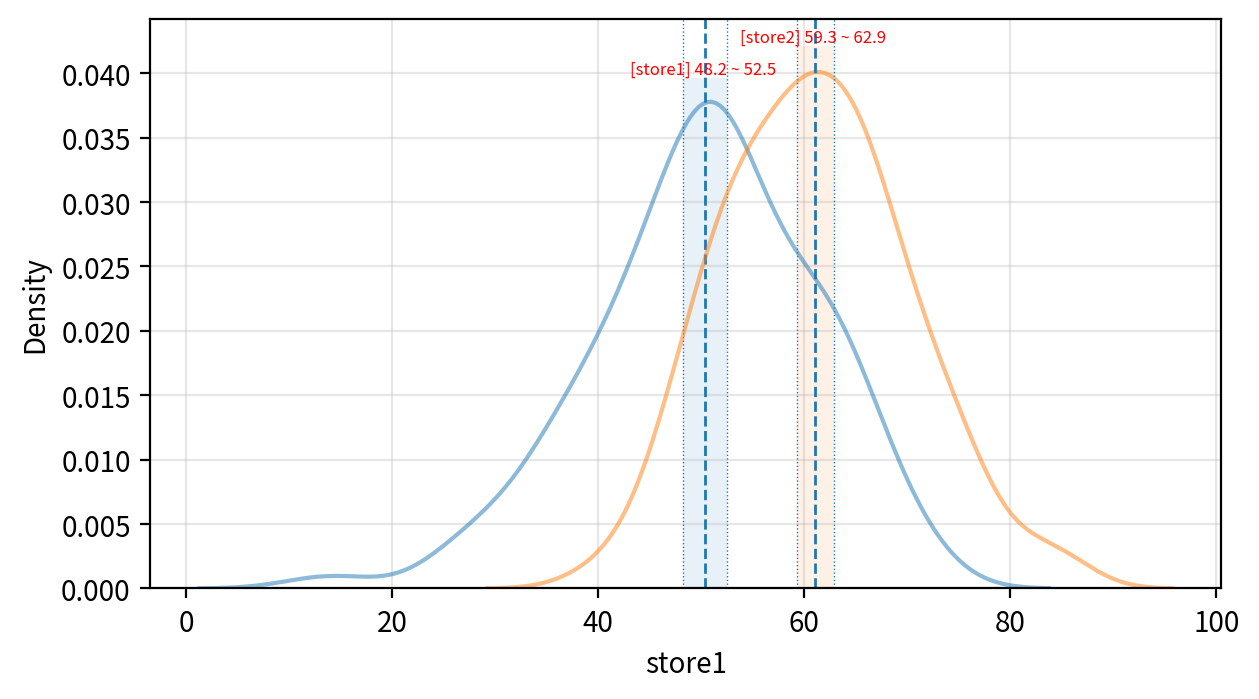

In [25]:
data = origin[['store1', 'store2']]


width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)


for c in data.columns:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    max = data[c].max()
    clevel = 0.95
    dof = len(data[c]) - 1
    sp_mean = data[c].mean()
    sp_std = data[c].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(data[c]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ax.text(x=(cmax-cmin)/2+cmin, y=ymax,
            s="[%s] %0.1f ~ %0.1f " % (c, cmin, cmax), horizontalalignment="center",
            verticalalignment="bottom",fontdict={"size":6, "color":"red"})

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()




In [26]:
data = origin[['store1', 'store2']]


equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    s,p = normaltest(data[c])

    normalize = p>0.05
    report.append({
         "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize


if len(data.columns)>1:
    if normal_dist:
        n = "Bartlett"

        s,p = bartlett(*data.values.T)

    else:
        n = "Levene"

        s,p = levene(*data.values.T, center="median")
        report.append({
            "field": n,
        "statistic": s,
        "p-value": p,
        "result": p>0.05
        })



report_df =DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
store1,5.651229,0.059272,True
store2,1.173772,0.556056,True


In [27]:
s, p = f_oneway(origin['store1'], origin['store2'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

In [28]:
df = melt(origin, var_name='store', value_name = 'sales')
df

,store,sales
0,store1,34
1,store1,63
2,store1,57
3,store1,50
4,store1,37
...,...,...
195,store2,69
196,store2,51
197,store2,65
198,store2,59


In [29]:
lm = ols('sales ~ C(store)',data=df).fit()
anova_result = anova_lm(lm)
anova_result

,df,sum_sq,mean_sq,F,PR(>F)
C(store),1.0,5735.205,5735.205000,58.717529,7.945482e-13
Residual,198.0,19339.550,97.674495,NaN,NaN


In [30]:
s = anova_result['F'].iloc[0]
p = anova_result['PR(>F)'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

In [31]:
anova_result = anova(data=df, dv='sales',between='store')
anova_result

,Source,ddof1,ddof2,F,p-unc,np2
0,store,1,198,58.717529,7.945482e-13,0.228724


In [32]:
s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

In [33]:
welch_anova(data=df, dv='sales', between='store')

,Source,ddof1,ddof2,F,p-unc,np2
0,store,1,192.521085,58.717529,8.694831e-13,0.228724


In [34]:
s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

In [35]:
tukey = pairwise_tukeyhsd(df['sales'], df['store'])
tukey_table = tukey.summary()
tukey_df = DataFrame(tukey_table.data[1:],columns = tukey_table.data[0])
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,store1,store2,10.71,0.0,7.9538,13.4662,True


In [36]:
tukey_df = pairwise_tukey(data=df, dv='sales', between='store')
tukey_df

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,8.714141e-13,-1.079565


In [37]:
comp = MultiComparison(df['sales'], df['store'])
result = comp.allpairtest(ttest_ind, method='bonf')
bonf_df = DataFrame(result[0].data[1:], columns=result[0].data[0])
bonf_df

,group1,group2,stat,pval,pval_corr,reject
0,store1,store2,-7.6627,0.0,0.0,True


In [38]:
bonf_df = pairwise_tests(data=df, dv='sales', between = 'store',padjust='bonf')
bonf_df

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,store,store1,store2,False,True,-7.662736,198.0,two-sided,7.945482e-13,8.14e+09,-1.079565


In [39]:
gh_df = pairwise_gameshowell(df, dv='sales',between='store')
gh_df

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,192.521085,9.281464e-13,-1.079565
